In [1]:
%config IPCompleter.greedy=True

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nlppreprocess import NLP as npl
from nltk.corpus import stopwords
import nltk
from collections import Counter
plt.style.use('default')
sns.set(style="whitegrid")
pd.options.display.float_format = '{:20,.2f}'.format 

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paola\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv("train.csv")
df.drop(columns='id', inplace=True)

In [5]:
df.size

30452

In [6]:
df.describe()

,target
count,"7,613.00"
mean,0.43
std,0.50
min,0.00
25%,0.00
50%,0.00
75%,1.00
max,1.00


In [7]:
df.dtypes

keyword     object
location    object
text        object
target       int64
dtype: object

In [8]:
len(df)

7613

In [9]:
df.keyword.value_counts()

fatalities               45
armageddon               42
deluge                   42
sinking                  41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [10]:
df.keyword.value_counts(sort=False)

whirlwind                39
collapsed                35
thunderstorm             33
danger                   36
wildfire                 33
                         ..
buildings%20on%20fire    33
rescue                   22
emergency%20plan         35
lightning                33
fatal                    38
Name: keyword, Length: 221, dtype: int64

In [11]:
df.location.value_counts()

USA               104
New York           71
United States      50
London             45
Canada             29
                 ... 
Killarney           1
Chester, IL         1
Paducah, KY         1
a box               1
New York ? ATL      1
Name: location, Length: 3341, dtype: int64

In [12]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [13]:
df['long']= df['text'].apply(lambda x: len(x))
long_max = df['long'].max()
long_max

157

In [14]:
long_min = df['long'].min()
long_min

7

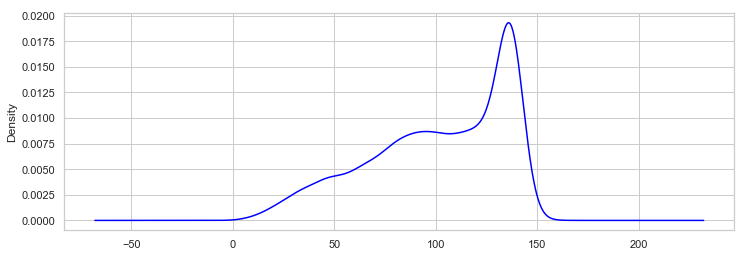

In [15]:
fig = plt.figure(figsize=(12,4))
df.long.plot.kde(color = 'Blue')
plt.show()

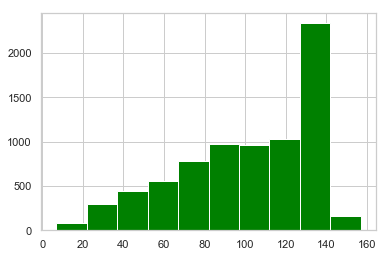

In [16]:
df.long.hist(color='green', bins=10)

In [17]:
long_mean = df['long'].mean()
long_mean

101.03743596479706

In [18]:
df.tail()

,keyword,location,text,target,long
7608,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83
7609,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125
7610,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65
7611,NaN,NaN,Police investigating after an e-bike collided ...,1,137
7612,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1,94


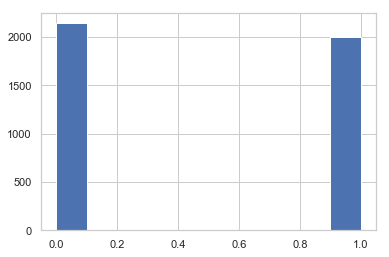

In [19]:
larger_than_mean = df[df['long'] > long_mean]
#larger_than_mean.groupby('target').plot.bar(x='target')
#larger_than_mean.plot.bar(x='target', y=sum(larger_than_mean.groupby('target')))
#plt.bar(larger_than_mean.target, larger_than_mean.target.count())
plt.hist(larger_than_mean.target)
plt.show()

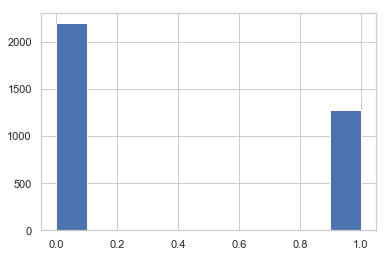

In [20]:
smaller_than_mean = df[df.long < long_mean]
plt.hist(smaller_than_mean.target)
plt.show()

In [21]:
#Busco si los que tienen localizacion tienen mas posibilidad de ser reales

with_loc = df[df.location.notna()]
with_loc.head()

,keyword,location,text,target,long
31,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55
32,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67
33,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82
34,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,34
35,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76


In [22]:
len(with_loc)

5080

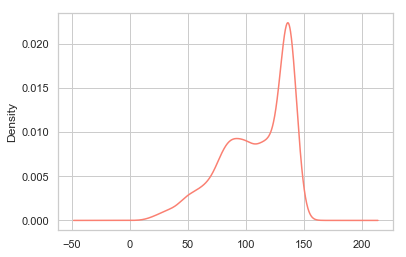

In [23]:
with_loc_real = with_loc[with_loc.target == 1]
with_loc_real.long.plot.kde(color='salmon')

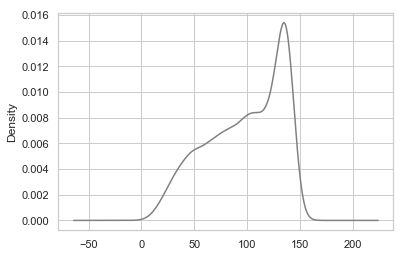

In [24]:
with_loc_false = with_loc[with_loc.target == 0]
with_loc_false.long.plot.kde(color='grey')

In [25]:
len(df.location.isna())

7613

In [26]:
no_loc = df[df.location.isna()]
no_loc.target.value_counts()

0    1458
1    1075
Name: target, dtype: int64

In [27]:
no_loc.tail()

,keyword,location,text,target,long
7608,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83
7609,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125
7610,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65
7611,NaN,NaN,Police investigating after an e-bike collided ...,1,137
7612,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1,94


In [28]:
def suma_target(grouped_k):
    grouped_k['target_suma']= grouped_k['target'].sum()
    return grouped_k

In [29]:
suma=0
#grouped_k['suma'] = df.groupby(['keyword', 'target']).apply(lambda x: suma + x for x in df['target'] if x== 1)
grouped_k= df.groupby(['keyword']).agg({'target':['sum','count']} ).reset_index()
#grouped_k['sum_target'] = grouped_k['target'].apply('sum')
#grouped_k['suma']= grouped_k.apply(lambda x: (suma + x) for x in grouped_k['target'] if (x== 1))
#grouped_k=df.groupby('keyword')#.apply(suma_target)
#grouped_kl['suma']=grouped_kl.target.apply(sum)
level0= grouped_k.columns.get_level_values(0)
level1= grouped_k.columns.get_level_values(1)
grouped_k.columns = level0 + '_' + level1
grouped_k.insert(loc=2, column='cant_falsas', value=(grouped_k.target_count - grouped_k.target_sum))
#col_rename{'target_sum' : 'cant_reales', 'keyword_':'keyword'})
grouped_k.rename(columns={'target_sum' : 'cant_reales', 'keyword_':'keyword'}, inplace=True)
grouped_k

,keyword,cant_reales,cant_falsas,target_count
0,ablaze,13,23,36
1,accident,24,11,35
2,aftershock,0,34,34
3,airplane%20accident,30,5,35
4,ambulance,20,18,38
...,...,...,...,...
216,wounded,26,11,37
217,wounds,10,23,33
218,wreck,7,30,37
219,wreckage,39,0,39


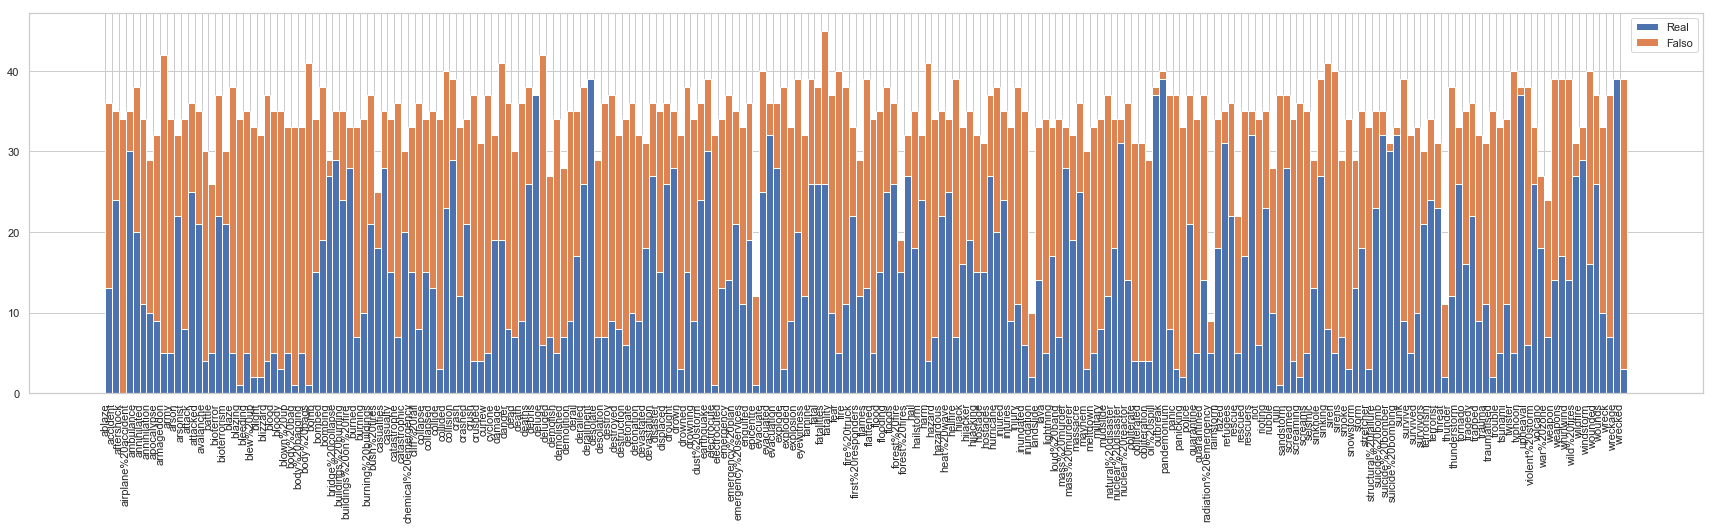

In [30]:
fig = plt.figure(figsize=(30,7))
ax = plt.subplot()
ax.bar(grouped_k.keyword, grouped_k.cant_reales, width = 1, label='Real', align = 'edge')
ax.bar(grouped_k.keyword, grouped_k.cant_falsas, width = 1, bottom=grouped_k.cant_reales, label='Falso', align = 'edge')
plt.xticks(rotation=90)

ax.legend()
plt.show()

In [31]:
stop = stopwords.words('english')

In [32]:
def cuenta_iguales(lista):
    newlist=[]
    for palabra in lista:
        if (lista.count(palabra) > 1):
            newlist.append(lista.count(palabra))
    return newlist

In [33]:
def cuenta_iguales(lista):
    c= Counter(lista)
    count=0
    for key in c:
        if (c[key]>1):
            count+=1
    return count

In [34]:
df['equal_words'] = df.text.agg(lambda x: cuenta_iguales([word for word in x.split() if word not in stop]))


In [35]:
df.head()

,keyword,location,text,target,long,equal_words
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,0
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,0
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,0
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,0
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,0


In [36]:
word_count = df.groupby(['equal_words'])['target'].agg({'sum','count'} ).reset_index()

In [37]:
word_count.head(30)

,equal_words,sum,count
0,0,2810,6465
1,1,353,905
2,2,76,182
3,3,16,37
4,4,11,15
5,5,3,5
6,6,0,1
7,8,1,2
8,9,1,1


Text(0.5,0,'Amount of repeated words')

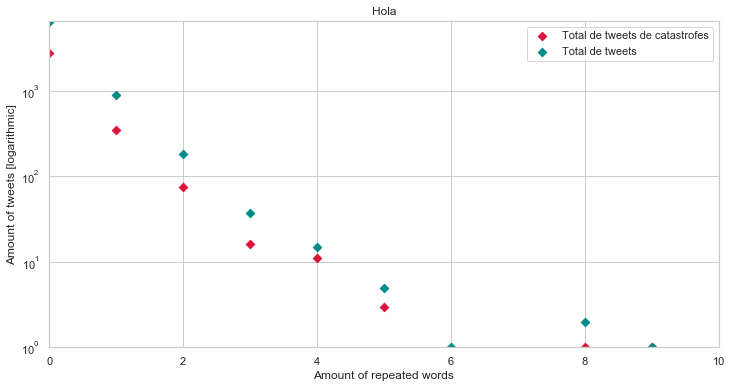

In [151]:
fig,ax = plt.subplots(figsize=(12,6))
cambio = lambda x: 'Total de tweets' if (x=='count') else 'Total de tweets de catastrofes'
colore= {'sum':'crimson', 'count': 'darkcyan'}
for name in ['sum','count']:
    ax.scatter(word_count.equal_words, word_count[name],  marker= 'D', label= cambio(name), c=colore[name])
    ax.set_ylim(1,6600)  
    ax.set_xlim(0,10)
    ax.set_yscale("log")
    plt.legend()
ax.set_title('Hola')
ax.set_ylabel('Amount of tweets [logarithmic]')
ax.set_xlabel('Amount of repeated words')

In [39]:
df['Tags']= df['text'].agg(lambda x: x.count('@'))

In [156]:
tag_count = df.groupby(['Tags'])['target'].agg({'sum','count'}).reset_index()
tag_count.head(20)

,Tags,sum,count
0,0,2595,5574
1,1,519,1553
2,2,102,343
3,3,41,87
4,4,11,31
5,5,3,18
6,6,0,5
7,7,0,1
8,8,0,1


Text(0.5,0,'Amount of tags in a tweet')

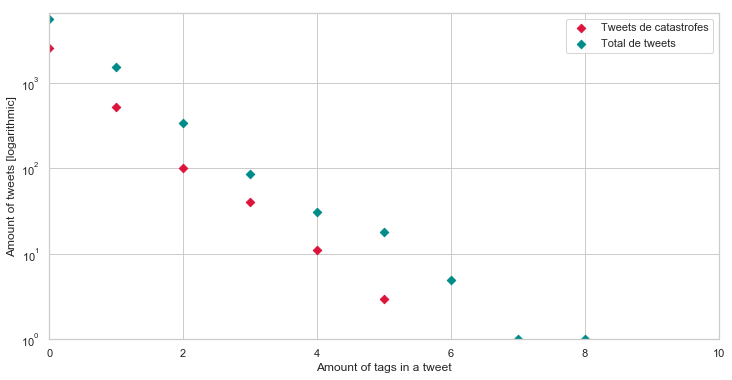

In [165]:

fig,ax = plt.subplots(figsize=(12,6))
tag_count.rename(columns={'sum' : 'Tweets de catastrofes', 'count':'Total de tweets'}, inplace=True)
colore= {'Tweets de catastrofes':'crimson', 'Total de tweets': 'darkcyan'}
for name in ['Tweets de catastrofes','Total de tweets']:
    ax.scatter(tag_count.Tags, tag_count[name],  marker= 'D' , label=name , c=colore[name])
    ax.set_ylim(1,6600)  
    ax.set_xlim(0,10)
    ax.set_yscale("log")
    ax.set_xlabel('Amount of tags in a tweet')
    ax.set_ylabel('Amount of tweets')
    plt.legend()
ax.set_title('')
ax.set_ylabel('Amount of tweets [logarithmic]')
ax.set_xlabel('Amount of tags in a tweet')

In [42]:
df['with_url']= df.text.str.contains("http")

df['with_url']=df['with_url'].astype(int)

In [140]:
url_count = df.groupby(['with_url'])['target'].agg({'sum','count'}).reset_index()

url_count.rename(columns={'sum' : 'Total de catastrofes', 'count':'Total de tweets'}, inplace=True)
url_count.head()

,with_url,Total de catastrofes,Total de tweets
0,0,1099,3642
1,1,2172,3971


[Text(0,0,'Without url'), Text(0,0,'With url')]

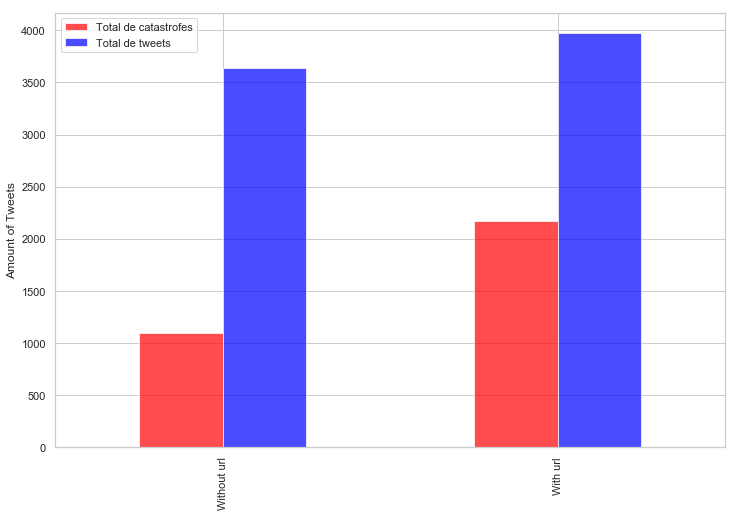

In [143]:
fig = url_count.set_index('with_url').plot(kind='bar', figsize=(12, 8), cmap="bwr_r", alpha=0.7)
fig.axes.set_ylabel('Amount of Tweets')
fig.axes.set_xlabel('')
fig.axes.set_xticklabels(['Without url', 'With url'])

In [112]:
df['with_date'] = df.text.str.contains('\w*\d\w*').astype(int)
date_count = df.groupby(['with_date'])['target'].agg({'sum','count'}).reset_index()
date_count.rename(columns={'sum' : 'Total de catastrofes', 'count':'Total de tweets'}, inplace=True)

[Text(0,0,'Without date'), Text(0,0,'With date')]

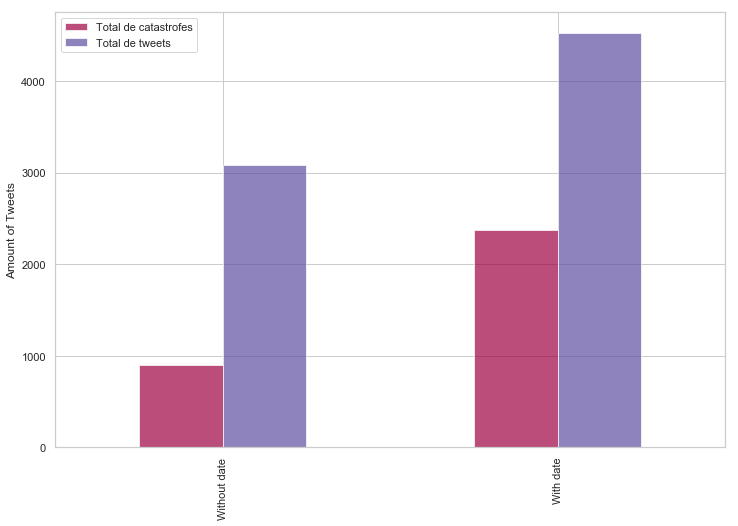

In [139]:

fig = date_count.set_index('with_date').plot(kind='bar', figsize=(12, 8), cmap="Spectral", alpha=0.7)
fig.axes.set_ylabel('Amount of Tweets')
fig.axes.set_xlabel('')
fig.axes.set_xticklabels(['Without date', 'With date'])

In [47]:
dfcor = df.drop(columns=['keyword', 'location', 'text', 'long'])

In [48]:
df2=dfcor.groupby('target').agg(['sum'])
level0= df2.columns.get_level_values(0)
level1= df2.columns.get_level_values(1)
df2.columns = level0 + '_' + level1
df2.head()

,equal_words_sum,Tags_sum,with_url_sum,with_date_sum
target,,,,
0,867,1854,1799,2155
1,629,905,2172,2370


[Text(0,0.5,'Not Catastrophe'), Text(0,1.5,'Catastrophe')]

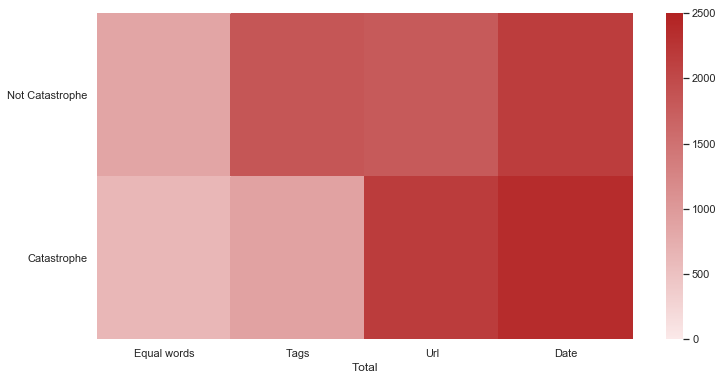

In [210]:
plt.figure(figsize=(12,6))
cmap = sns.light_palette(color='firebrick',as_cmap=True)
fig=sns.heatmap(df2, vmin=0, vmax=2500, cmap=cmap,
            xticklabels=['Equal words', 'Tags', 'Url', 'Date'], 
            yticklabels=['Not Catastrophe', 'Catastrophe'], robust=True)
fig.set(xlabel="Total",
      ylabel="")

fig.set_yticklabels(fig.get_yticklabels(), rotation =0)

In [55]:
df3=dfcor.groupby('target').agg(['mean'])
level0= df3.columns.get_level_values(0)
level1= df3.columns.get_level_values(1)
df3.columns = level0 + '_' + level1
df3.head()

,equal_words_mean,Tags_mean,with_url_mean,with_date_mean
target,,,,
0,0.20,0.43,0.41,0.50
1,0.19,0.28,0.66,0.72


[Text(0,0.5,'Not Catastrophe'), Text(0,1.5,'Catastrophe')]

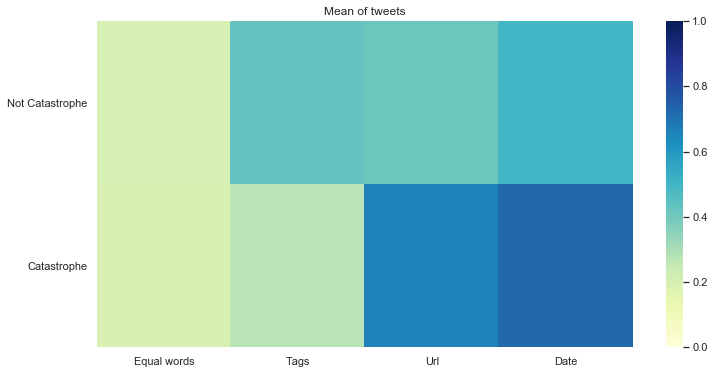

In [163]:
plt.figure(figsize=(12,6))
fig = sns.heatmap(df3, vmin=0, vmax=1, cmap="YlGnBu", 
                  xticklabels=['Equal words', 'Tags', 'Url', 'Date'], 
                  yticklabels=['Not Catastrophe', 'Catastrophe'], robust = True)
fig.set(title='Mean of tweets', xlabel="", ylabel="")

fig.set_yticklabels(fig.get_yticklabels(), rotation =0)

In [170]:
dfcorrr= dfcor.corr() 
dfcorrr

,target,equal_words,Tags,with_url,with_date
target,1.00,-0.01,-0.10,0.25,0.23
equal_words,-0.01,1.00,-0.03,-0.04,-0.01
Tags,-0.10,-0.03,1.00,-0.22,-0.07
with_url,0.25,-0.04,-0.22,1.00,0.67
with_date,0.23,-0.01,-0.07,0.67,1.00


[Text(0,0.5,'target'),
 Text(0,1.5,'Equal words'),
 Text(0,2.5,'Tags'),
 Text(0,3.5,'Url'),
 Text(0,4.5,'Date')]

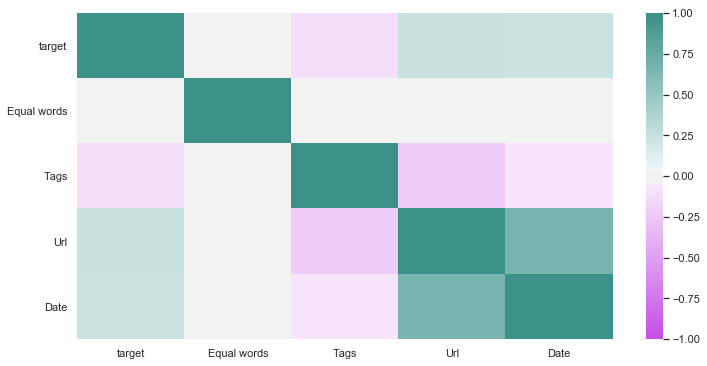

In [192]:
plt.figure(figsize=(12,6))
cmap = sns.diverging_palette(295, 180, s=80, l=55, as_cmap=True)
fig=sns.heatmap(dfcorrr, vmin=-1, vmax=1, cmap=cmap,
            xticklabels=['target','Equal words', 'Tags', 'Url', 'Date'], 
            yticklabels=['target','Equal words', 'Tags', 'Url', 'Date'], robust=True)
fig.set(xlabel="",
      ylabel="")

fig.set_yticklabels(fig.get_yticklabels(), rotation =0)